### K-means vs DBSCAN: Wholesale Customers Dataset Analysis

A comprehensive clustering analysis comparing K-means and DBSCAN algorithms on the UCI Wholesale Customers Dataset. This project performs customer segmentation to identify distinct purchasing patterns and provide actionable business insights.

**Dataset**: The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on different product categories i.e., Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen; plus Channel/Region information.


In [ ]:
# Import necessary libraries
import pandas as pd                   # Data manipulation and analysis
import numpy as np                    # Numerical computing and arrays
import matplotlib.pyplot as plt       # Plotting and data visualization
import seaborn as sns                 # Statistical data visualization
from sklearn.preprocessing import RobustScaler          # Scaling features while reducing outlier influence
from sklearn.cluster import KMeans, DBSCAN              # Clustering algorithms; KMeans and DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score   # Metrics to evaluate clustering quality
from sklearn.decomposition import PCA                   # Dimensionality reduction using Principal Component Analysis
from sklearn.neighbors import NearestNeighbors          # Finding nearest neighbors which useful for DBSCAN parameter tuning
from scipy import stats                                 # Statistical functions and tests
from scipy.stats import kruskal                         # Kruskal–Wallis non-parametric statistical test
from scipy.spatial.distance import cdist                # Compute pairwise distances between points

import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Constants
SPENDING_COLS = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
CATEGORICAL_COLS = ['Channel', 'Region']
CHANNEL_MAP = {1: 'Horeca', 2: 'Retail'} #Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
REGION_MAP = {1: 'Lisbon', 2: 'Oporto', 3: 'Other'} #Region - Lisbon, Oporto or Other (Nominal)

print("Libraries imported successfully!")


Libraries imported successfully!


## Part A: Data Loading & Preprocessing


In [3]:
# Load the dataset
df = pd.read_csv('dataset/Wholesale-customers-data.csv')

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst 10 rows:")
print(df.head(10))


Dataset loaded successfully!

Dataset shape: (440, 8)

First 10 rows:
   Channel  Region  Fresh   Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669   9656     7561     214              2674   
1        2       3   7057   9810     9568    1762              3293   
2        2       3   6353   8808     7684    2405              3516   
3        1       3  13265   1196     4221    6404               507   
4        2       3  22615   5410     7198    3915              1777   
5        2       3   9413   8259     5126     666              1795   
6        2       3  12126   3199     6975     480              3140   
7        2       3   7579   4956     9426    1669              3321   
8        1       3   5963   3648     6192     425              1716   
9        2       3   6006  11093    18881    1159              7425   

   Delicassen  
0        1338  
1        1776  
2        7844  
3        1788  
4        5185  
5        1451  
6         545  
7        2566  
8   

In [4]:
# Show column types and basic info
print("Column types:")
print(df.dtypes)
print("\n" + "_"*50)
print("\nDataset info:")
print(df.info())
print("\n" + "_"*50)
print("\nBasic statistics:")
print(df.describe())


Column types:
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

__________________________________________________

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

__________________________________________________

Basic statistics:
          Channel      Regio

In [33]:
# Handle missing data
print("Missing values per column:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing values: {missing.sum()}")

if missing.sum() > 0:
    print("\nStrategy: Missing values detected. We will:")
    print("1. For numeric columns: Use median imputation")
    print("2. For categorical columns: Use mode imputation")
    # Uncomment if needed:
    # from sklearn.impute import SimpleImputer
    # numeric_imputer = SimpleImputer(strategy='median')
    # categorical_imputer = SimpleImputer(strategy='most_frequent')
else:
    print("\nNo missing values found. No imputation needed.")


Missing values per column:
Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Total missing values: 0

No missing values found. No imputation needed.


In [5]:
# Remove exact duplicates
initial_shape = df.shape
print(f"Initial dataset shape: {initial_shape}")

df_clean = df.drop_duplicates()
final_shape = df_clean.shape
print(f"After removing duplicates: {final_shape}")
print(f"Duplicates removed: {initial_shape[0] - final_shape[0]}")

df = df_clean.copy()
print(f"\nFinal dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")


Initial dataset shape: (440, 8)
After removing duplicates: (440, 8)
Duplicates removed: 0

Final dataset dimensions: 440 rows × 8 columns


In [35]:
# Helper function for outlier detection using IQR method
def detect_outliers_iqr(data, columns, iqr_multiplier=1.5):
    
    #Detect outliers using IQR method and return counts.
    outlier_info = {}
    for col in columns:
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower = Q1 - iqr_multiplier * IQR
        upper = Q3 + iqr_multiplier * IQR
        mask = (data[col] < lower) | (data[col] > upper)
        outlier_info[col] = {'count': mask.sum(), 'pct': mask.mean() * 100}
    return outlier_info

# Check for outliers
print("Outlier detection using IQR method (values beyond 1.5*IQR):")
outlier_info = detect_outliers_iqr(df, SPENDING_COLS)
for col, info in outlier_info.items():
    print(f"{col}: {info['count']} outliers ({info['pct']:.2f}%)")

# Scale features using RobustScaler (robust to outliers)
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[SPENDING_COLS] = scaler.fit_transform(df[SPENDING_COLS])

print("\nNumeric features scaled using RobustScaler (robust to outliers)")
print("\nScaled data sample:")
print(df_scaled[SPENDING_COLS].head())


Outlier detection using IQR method (values beyond 1.5*IQR):
Fresh: 20 outliers (4.55%)
Milk: 28 outliers (6.36%)
Grocery: 24 outliers (5.45%)
Frozen: 43 outliers (9.77%)
Detergents_Paper: 30 outliers (6.82%)
Delicassen: 27 outliers (6.14%)

Numeric features scaled using RobustScaler (robust to outliers)

Scaled data sample:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.301680  1.065712  0.329952 -0.466572          0.506787    0.263810
1 -0.104810  1.092934  0.565993  0.083926          0.675670    0.574008
2 -0.155802  0.915816  0.344418  0.312589          0.736512    4.871459
3  0.344850 -0.429714 -0.062862  1.734708         -0.084442    0.582507
4  1.022092  0.315171  0.287260  0.849573          0.262056    2.988314


In [36]:
# Encode Channel and Region for interpretation (not used in clustering)
df['Channel_label'] = df['Channel'].map(CHANNEL_MAP)
df['Region_label'] = df['Region'].map(REGION_MAP)

print("Channel encoding:")
print(df['Channel'].value_counts().sort_index())
print("\nRegion encoding:")
print(df['Region'].value_counts().sort_index())
print("\nChannel and Region encoded for interpretation only")
print("Note: These categorical features are NOT included in clustering distance calculations")


Channel encoding:
Channel
1    298
2    142
Name: count, dtype: int64

Region encoding:
Region
1     77
2     47
3    316
Name: count, dtype: int64

Channel and Region encoded for interpretation only
Note: These categorical features are NOT included in clustering distance calculations


## Part B: First Exploratory Data Analysis


In [37]:
# Descriptive statistics for spending categories
print("Descriptive Statistics for Spending Categories:")
print("_"*65)
print(df[SPENDING_COLS].describe())


Descriptive Statistics for Spending Categories:
_________________________________________________________________
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.250000  10655.750000   3554.250000   
max    112151.000000  73498.000000  92780.000000  60869.000000   

       Detergents_Paper    Delicassen  
count        440.000000    440.000000  
mean        2881.493182   1524.870455  
std         4767.854448   2820.105937  
min            3.000000      3.000000  
25%          256.750000    408.250000  
50%          816.500000    965.500000  
75%        

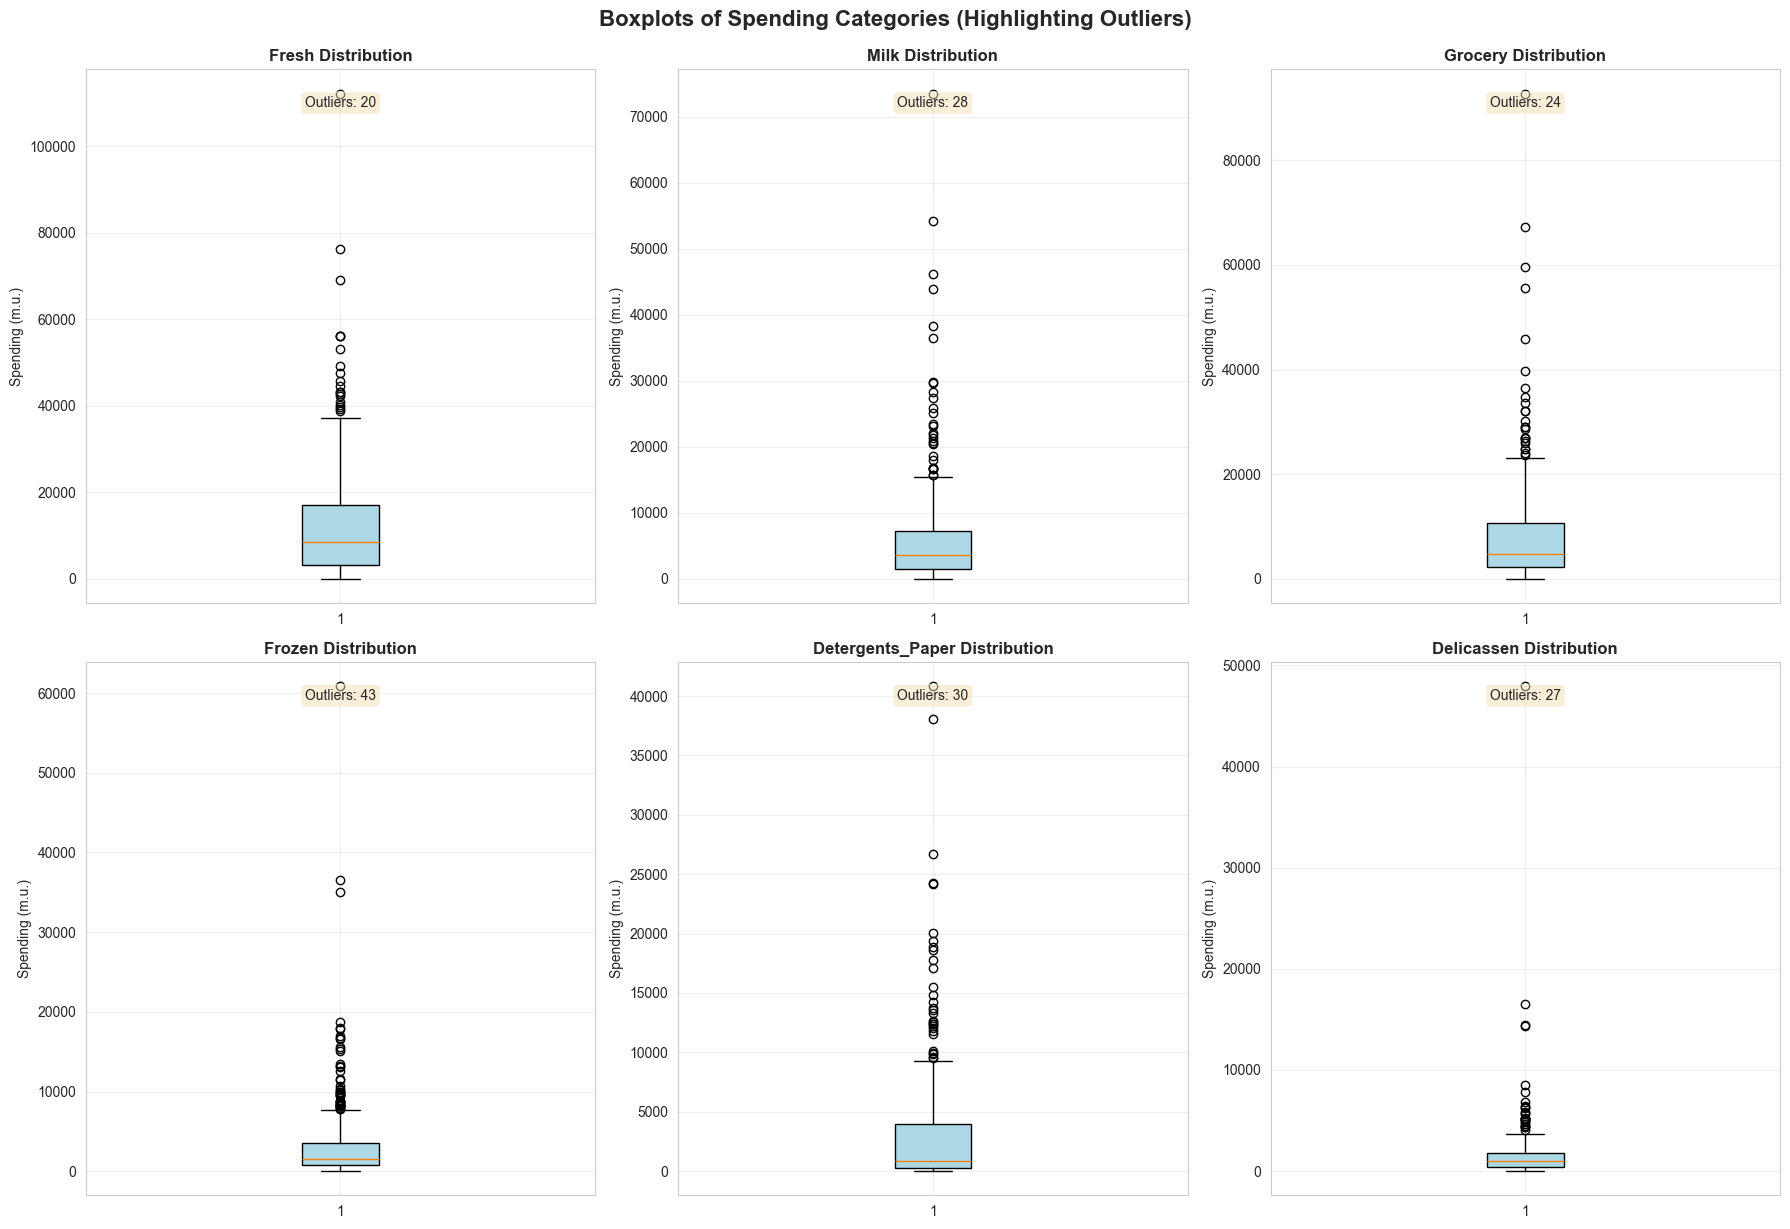


Outlier Summary:
__________________________________________________
Fresh               :  20 outliers ( 4.55%)
Milk                :  28 outliers ( 6.36%)
Grocery             :  24 outliers ( 5.45%)
Frozen              :  43 outliers ( 9.77%)
Detergents_Paper    :  30 outliers ( 6.82%)
Delicassen          :  27 outliers ( 6.14%)

Total outlier instances across all categories: 172


In [ ]:
# Creating boxplots for the spending categories. Highlighting outliers and giving counts. 
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(SPENDING_COLS):
    ax = axes[idx]
    box = ax.boxplot(df[col], vert=True, patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Spending (m.u.)')
    ax.grid(True, alpha=0.3)
    
    # Add outlier count annotation
    outlier_count = outlier_info[col]['count']
    ax.text(0.5, 0.95, f'Outliers: {outlier_count}', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.suptitle('Boxplots of Spending Categories (Highlighting Outliers)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Summary of outliers
print("\nOutlier Summary:")
print("_"*50)
total_outliers = sum(info['count'] for info in outlier_info.values())
for col, info in outlier_info.items():
    print(f"{col:20s}: {info['count']:3d} outliers ({info['pct']:5.2f}%)")
print(f"\nTotal outlier instances across all categories: {total_outliers}")


In [39]:
# Check skewness and identify highly skewed variables
print("Skewness before log transformation:")
print("_"*35)
skewness_before = df[SPENDING_COLS].skew()
for col, skew in skewness_before.items():
    print(f"{col:20s}: {skew:7.3f}")

# Identify highly skewed variables (|skewness| > 1)
highly_skewed = skewness_before[abs(skewness_before) > 1].index.tolist()
print(f"\nHighly skewed variables (|skewness| > 1): {highly_skewed}")

# Log transform highly skewed variables
df_log = df.copy()
if highly_skewed:
    for col in highly_skewed:
        df_log[f'Log_{col}'] = np.log1p(df[col])
    print(f"\nLog-transformed variables: {[f'Log_{col}' for col in highly_skewed]}")
else:
    print("\nNo highly skewed variables found.")


Skewness before log transformation:
___________________________________
Fresh               :   2.561
Milk                :   4.054
Grocery             :   3.587
Frozen              :   5.908
Detergents_Paper    :   3.632
Delicassen          :  11.152

Highly skewed variables (|skewness| > 1): ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

Log-transformed variables: ['Log_Fresh', 'Log_Milk', 'Log_Grocery', 'Log_Frozen', 'Log_Detergents_Paper', 'Log_Delicassen']


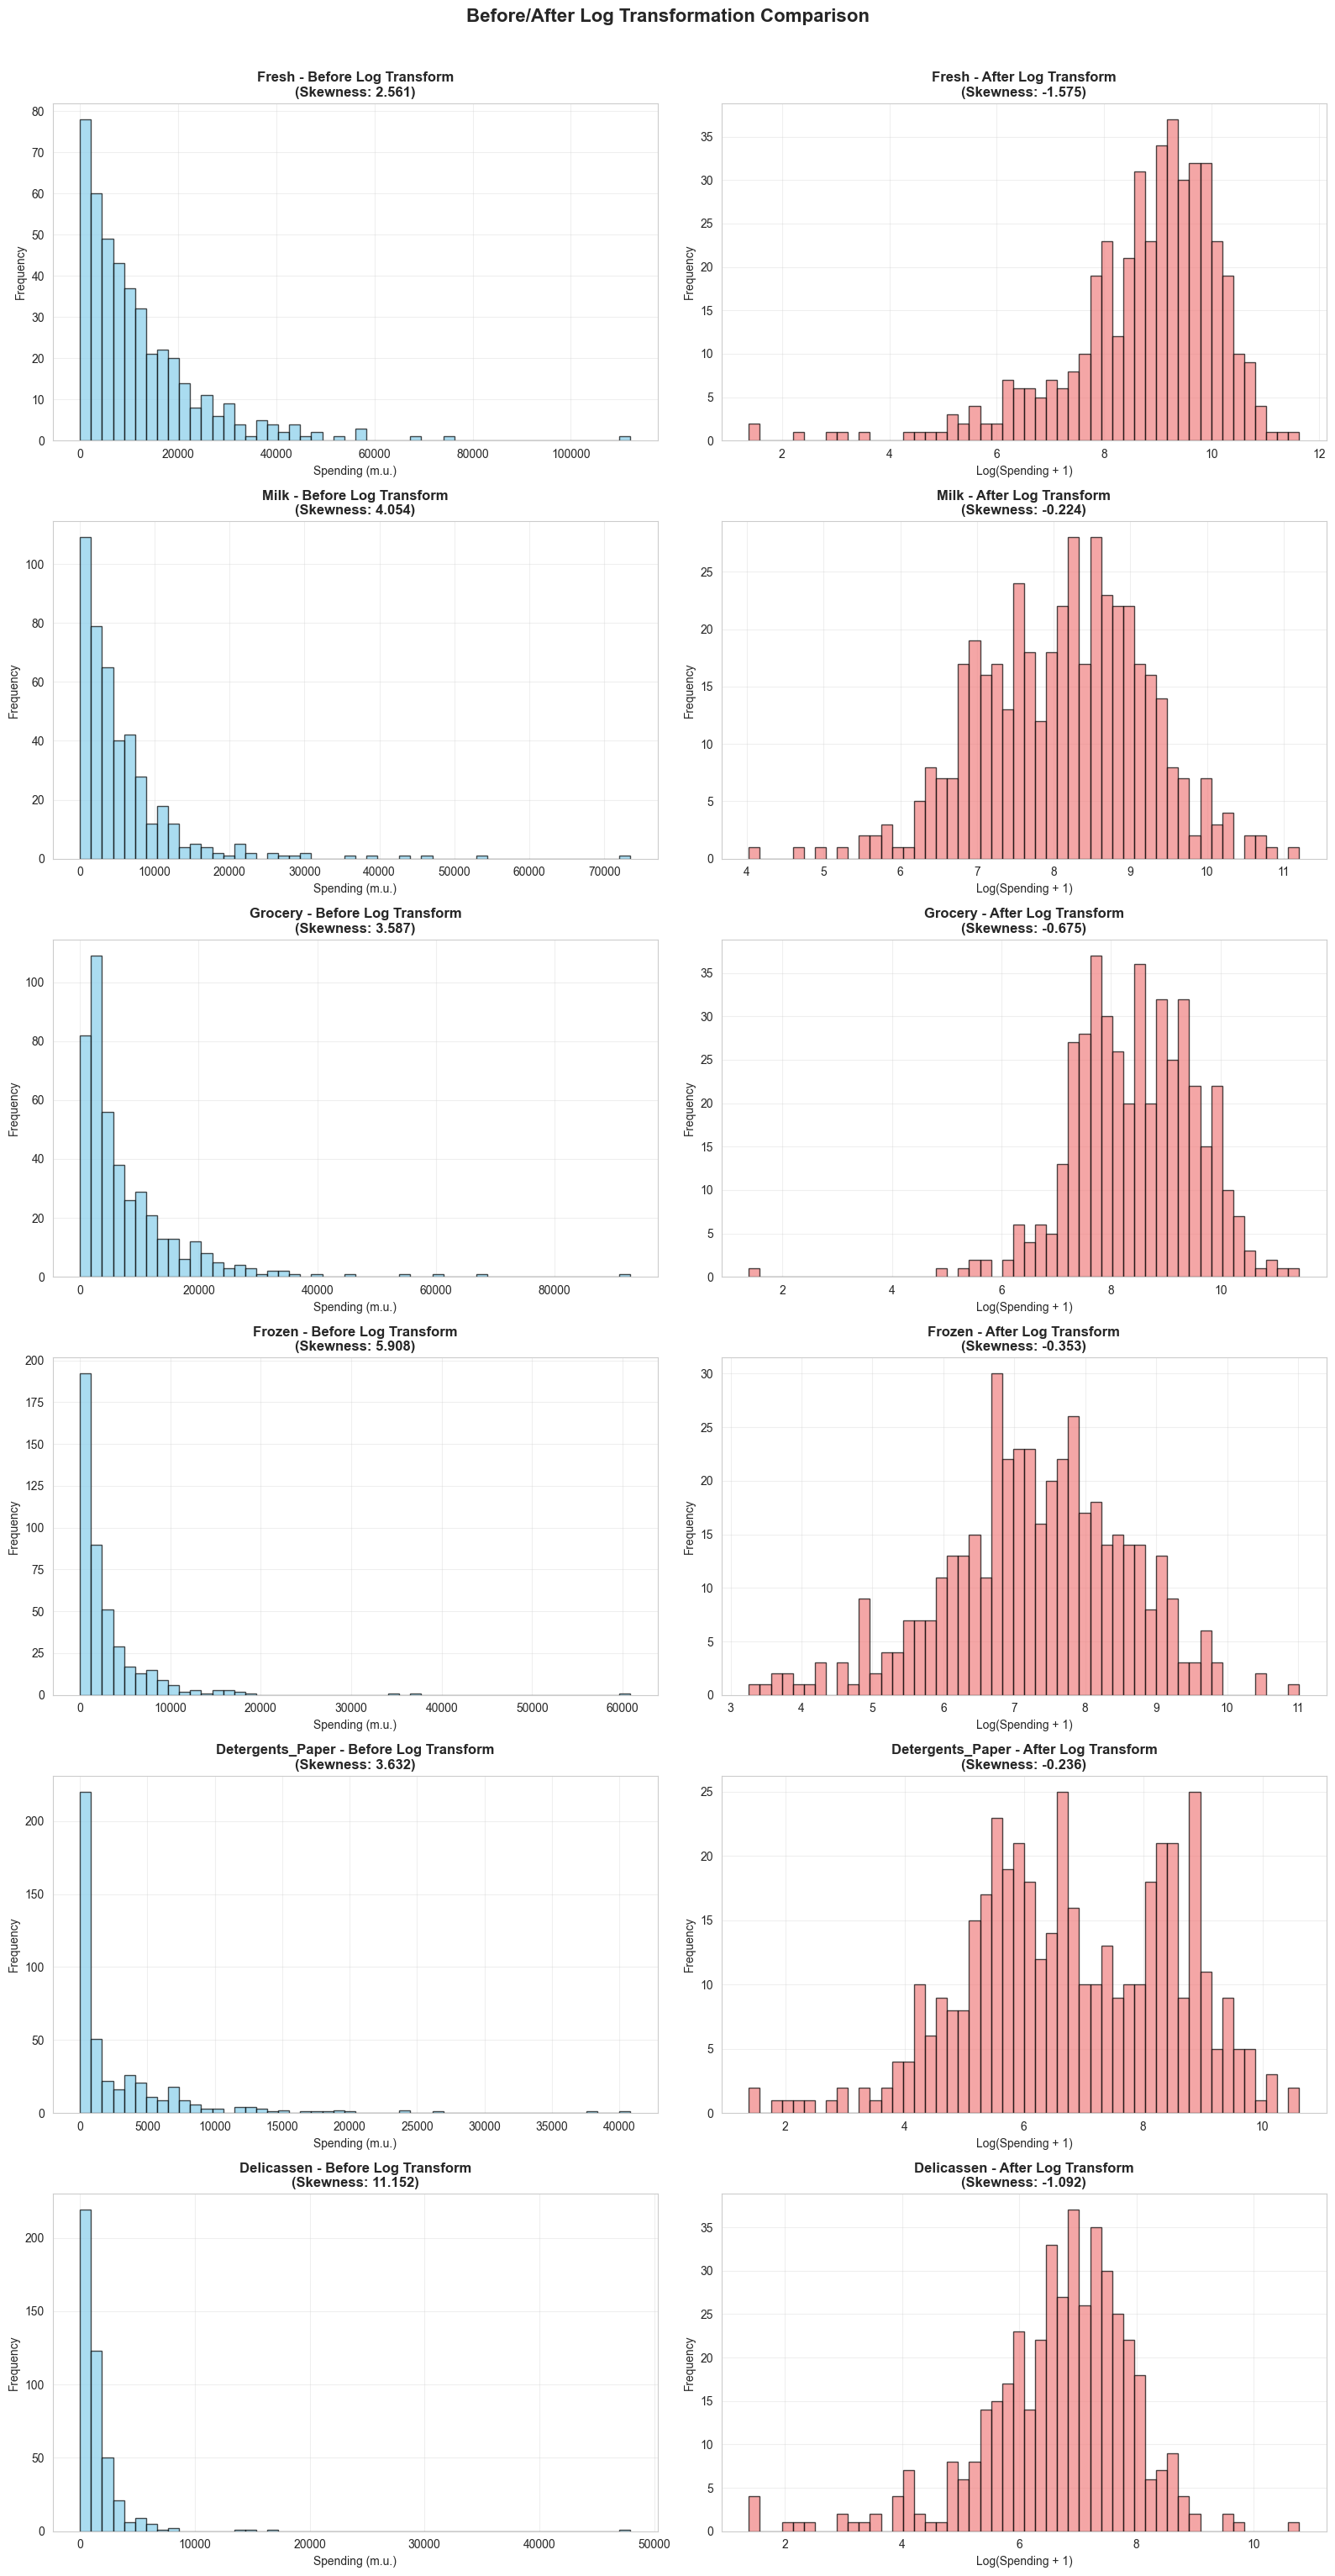


Skewness after log transformation:
________________________________________
Log_Fresh                :  -1.575
Log_Milk                 :  -0.224
Log_Grocery              :  -0.675
Log_Frozen               :  -0.353
Log_Detergents_Paper     :  -0.236
Log_Delicassen           :  -1.092


In [40]:
# Show before/after histograms for log-transformed variables
n_skewed = len(highly_skewed)
if n_skewed > 0:
    fig, axes = plt.subplots(n_skewed, 2, figsize=(16, 5*n_skewed))
    if n_skewed == 1:
        axes = axes.reshape(1, -1)
    
    for idx, col in enumerate(highly_skewed):
        # Before transformation
        axes[idx, 0].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'{col} - Before Log Transform\n(Skewness: {skewness_before[col]:.3f})', 
                              fontweight='bold')
        axes[idx, 0].set_xlabel('Spending (m.u.)')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # After transformation
        log_col = f'Log_{col}'
        skew_after = df_log[log_col].skew()
        axes[idx, 1].hist(df_log[log_col], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx, 1].set_title(f'{col} - After Log Transform\n(Skewness: {skew_after:.3f})', 
                              fontweight='bold')
        axes[idx, 1].set_xlabel('Log(Spending + 1)')
        axes[idx, 1].set_ylabel('Frequency')
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Before/After Log Transformation Comparison', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
    print("\nSkewness after log transformation:")
    print("_"*40)
    for col in highly_skewed:
        log_col = f'Log_{col}'
        print(f"{log_col:25s}: {df_log[log_col].skew():7.3f}")
else:
    print("No highly skewed variables found. Log transformation not needed.")


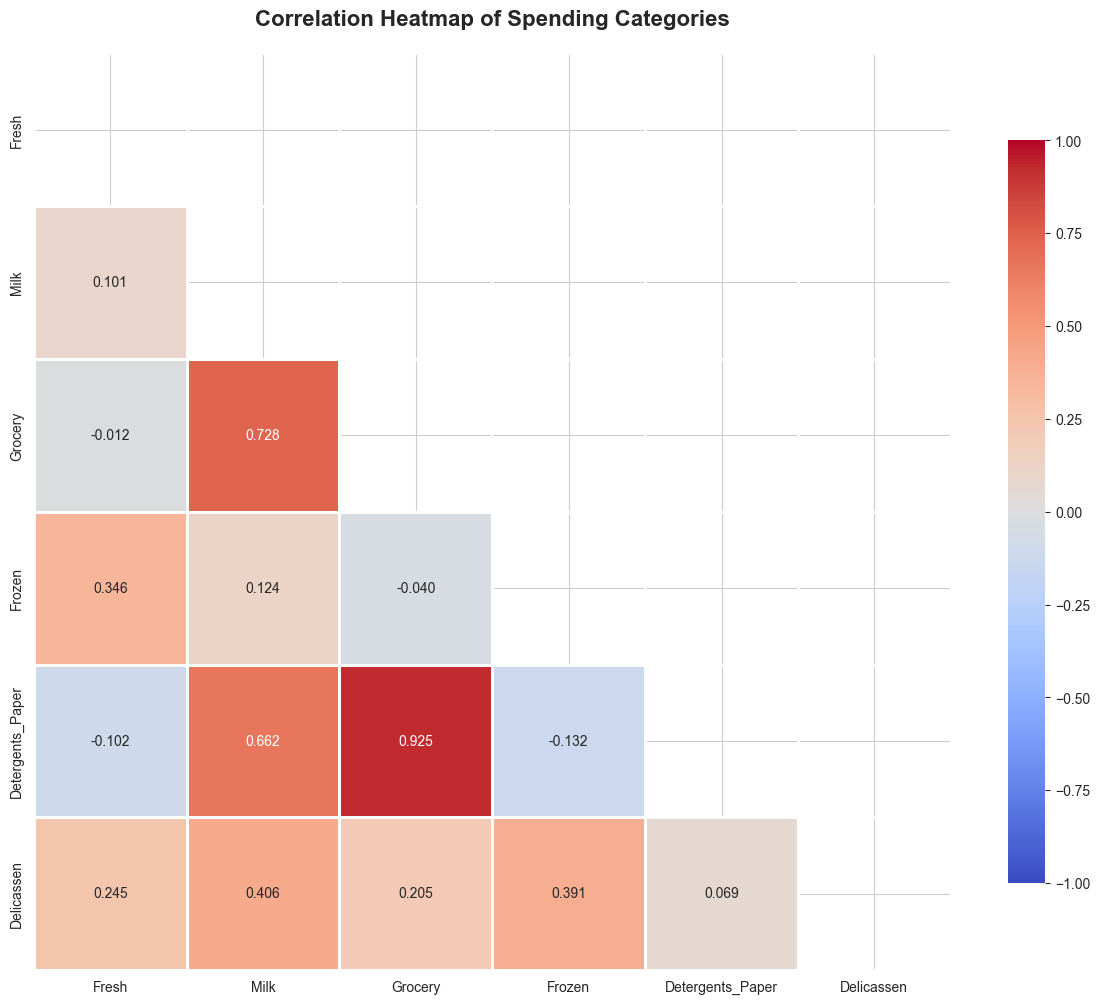


Co-purchasing Pattern Analysis:
________________________________________________________________________________

Strong correlations (|r| > 0.5) indicate co-purchasing patterns:
  Grocery              ↔ Detergents_Paper    :  0.925
  Milk                 ↔ Grocery             :  0.728
  Milk                 ↔ Detergents_Paper    :  0.662

Key Insights:
  • High correlation suggests customers who buy one category also buy the other
  • This can inform cross-selling strategies and inventory management


In [41]:
# Correlation heatmap of spending categories
correlation_matrix = df[SPENDING_COLS].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Spending Categories', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Analyze co-purchasing patterns
print("\nCo-purchasing Pattern Analysis:")
print("_"*80)
print("\nStrong correlations (|r| > 0.5) indicate co-purchasing patterns:")

# Extract strong correlations efficiently
strong_corr = []
for i, col1 in enumerate(SPENDING_COLS):
    for col2 in SPENDING_COLS[i+1:]:
        corr_val = correlation_matrix.loc[col1, col2]
        if abs(corr_val) > 0.5:
            strong_corr.append((col1, col2, corr_val))

if strong_corr:
    for col1, col2, corr in sorted(strong_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {col1:20s} ↔ {col2:20s}: {corr:6.3f}")
else:
    print("  No strong correlations found (|r| > 0.5)")

print("\nKey Insights:")
print("  • High correlation suggests customers who buy one category also buy the other")
print("  • This can inform cross-selling strategies and inventory management")


## Part C: Feature Engineering & Aggregation


In [43]:
# Create derived features efficiently
df_features = df.copy()

# Feature 1: TotalSpend
df_features['TotalSpend'] = df[SPENDING_COLS].sum(axis=1)

# Feature 2: ProportionFresh
df_features['ProportionFresh'] = df['Fresh'] / df_features['TotalSpend']

# Feature 3: LogTotalSpend
df_features['LogTotalSpend'] = np.log1p(df_features['TotalSpend'])

# Feature 4: GroceryMilkRatio
df_features['GroceryMilkRatio'] = df['Grocery'] / (df['Milk'] + 1)

# Feature 5: NonFreshProportion
df_features['NonFreshProportion'] = 1 - df_features['ProportionFresh']

# Display feature statistics
features_info = {
    'TotalSpend': ('sum of all spending categories', 'm.u.'),
    'ProportionFresh': ('Fresh / TotalSpend', ''),
    'LogTotalSpend': ('log(1 + TotalSpend)', ''),
    'GroceryMilkRatio': ('Grocery / (Milk + 1)', ''),
    'NonFreshProportion': ('1 - ProportionFresh', '')
}

print("Feature Engineering Summary:")
print("_"*50)
for feat, (desc, unit) in features_info.items():
    values = df_features[feat]
    print(f"\n{feat}: {desc}")
    print(f"   Range: {values.min():.2f} - {values.max():.2f} {unit}")
    print(f"   Mean: {values.mean():.2f} {unit}")

print("\n" + "_"*50)
print("Feature Engineering Complete!")


Feature Engineering Summary:
__________________

TotalSpend: sum of all spending categories
   Range: 904.00 - 199891.00 m.u.
   Mean: 33226.14 m.u.

ProportionFresh: Fresh / TotalSpend
   Range: 0.00 - 0.95 
   Mean: 0.38 

LogTotalSpend: log(1 + TotalSpend)
   Range: 6.81 - 12.21 
   Mean: 10.17 

GroceryMilkRatio: Grocery / (Milk + 1)
   Range: 0.00 - 21.02 
   Mean: 1.82 

NonFreshProportion: 1 - ProportionFresh
   Range: 0.05 - 1.00 
   Mean: 0.62 

__________________
Feature Engineering Complete!


### Justification for Derived Features:

1. *TotalSpend*: Captures overall customer value and spending capacity. Essential for segmenting high-value vs low-value customers.

2. *ProportionFresh*: Reveals customer preference for fresh vs processed products. Helps identify customer segments with different product preferences.

3. *LogTotalSpend*: Normalizes the highly skewed total spending distribution, making it more suitable for clustering algorithms that assume normal distributions.

4. *GroceryMilkRatio*: Identifies customers who prefer grocery items over milk products, useful for product mix optimization.

5. *NonFreshProportion*: Complements ProportionFresh by focusing on processed/frozen products, important for supply chain planning.
